 # Power Load Prediction for West Zone - Linear Model (24 hrs)

In [321]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [322]:
power_data_west = pd.read_csv("westdata_augmented.csv")

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_79757/1727164072.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  power_data_west = pd.read_csv("westdata_augmented.csv")


In [323]:
power_data_west['end'] = pd.to_datetime(power_data_west['end'], infer_datetime_format=True)
indexedDataset = power_data_west.set_index(['end'])

In [324]:
power_data_west['end'].min()

Timestamp('2019-01-29 00:15:00')

In [325]:
power_data_west['end'].max()

Timestamp('2022-01-25 16:00:00')

In [326]:
power_data_west.head()

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,sfm,index_y,dt,dt_iso,humidity,humidity_temp,pt_date
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01


In [327]:
power_data_west['month'] = power_data_west['end'].dt.strftime('%b')

In [328]:
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
power_data_west['month_int'] = power_data_west['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

In [329]:
power_data_west['day_of_week'] = power_data_west['end'].dt.day_name()

In [330]:
power_data_west['day_of_week_int'] = power_data_west['end'].dt.day_of_week

In [331]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

date_range = pd.date_range(start='2019-01-01', end='2022-01-27')

cal = calendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

power_data_west['holiday'] = power_data_west['end'].dt.date.astype('datetime64').isin(holidays)

In [332]:
power_data_west["holiday_int"] = power_data_west["holiday"].astype(int)

In [333]:
power_data_west_mod = power_data_west[['end','demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [334]:
power_data_west_mod.head()

,end,demand,temp,humidity,month_int,day_of_week_int,holiday_int
0,2019-01-29 00:15:00,844.8,54.0,21,1,1,0
1,2019-01-29 00:30:00,841.6,54.0,21,1,1,0
2,2019-01-29 00:45:00,832.0,54.0,21,1,1,0
3,2019-01-29 01:00:00,848.0,54.0,21,1,1,0
4,2019-01-29 01:15:00,812.8,55.0,21,1,1,0


In [335]:
power_data_west_mod.describe()

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
count,104596.000000,104588.00000,104608.000000,104608.00000,104608.000000,104608.000000
mean,1238.634456,67.39232,52.635401,6.54298,2.998748,0.028449
std,302.399419,16.59371,22.815913,3.43464,2.002753,0.166253
min,0.000000,29.00000,3.000000,1.00000,0.000000,0.000000
25%,1008.000000,54.00000,34.000000,4.00000,1.000000,0.000000
50%,1232.000000,66.00000,49.000000,7.00000,3.000000,0.000000
75%,1472.000000,79.00000,70.000000,10.00000,5.000000,0.000000
max,2124.800000,114.00000,100.000000,12.00000,6.000000,1.000000


In [336]:
power_data_west_mod.shape

(104608, 7)

In [337]:
power_data_west_24 = power_data_west_mod.resample('D', on='end').agg({'demand':'sum', 'temp':'max', 'humidity':'max', 'month_int':'max', 'day_of_week_int':'max', 'holiday_int':'max'})

In [338]:
power_data_west_24.describe()

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
count,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000
mean,118532.671171,79.911253,70.422690,6.537054,2.998170,0.028362
std,28166.774387,16.415071,19.585791,3.443121,2.000915,0.166082
min,1155.200000,44.000000,12.000000,1.000000,0.000000,0.000000
25%,96940.800000,66.000000,55.000000,4.000000,1.000000,0.000000
50%,117507.200000,79.000000,70.000000,7.000000,3.000000,0.000000
75%,141232.000000,95.000000,90.000000,10.000000,5.000000,0.000000
max,190041.600000,114.000000,100.000000,12.000000,6.000000,1.000000


In [339]:
power_data_west_24

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
end,,,,,,
2019-01-29,87331.2,65.0,88,1,1,0
2019-01-30,94944.0,71.0,89,1,2,0
2019-01-31,94940.8,60.0,92,1,3,0
2019-02-01,92905.6,63.0,79,2,4,0
2019-02-02,87206.4,66.0,93,2,5,0
...,...,...,...,...,...,...
2022-01-21,114214.4,60.0,92,1,4,0
2022-01-22,88096.0,66.0,91,1,5,0
2022-01-23,83523.2,68.0,61,1,6,0


In [340]:
power_data_west_24 = power_data_west_24[['demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [341]:
power_data_west_24

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
end,,,,,,
2019-01-29,87331.2,65.0,88,1,1,0
2019-01-30,94944.0,71.0,89,1,2,0
2019-01-31,94940.8,60.0,92,1,3,0
2019-02-01,92905.6,63.0,79,2,4,0
2019-02-02,87206.4,66.0,93,2,5,0
...,...,...,...,...,...,...
2022-01-21,114214.4,60.0,92,1,4,0
2022-01-22,88096.0,66.0,91,1,5,0
2022-01-23,83523.2,68.0,61,1,6,0


In [342]:
for i in range(1, 10):
    power_data_west_24["demand_lag_{}".format(i)] = power_data_west_24['demand'].shift(i)
    power_data_west_24["temp_lag_{}".format(i)] = power_data_west_24['temp'].shift(i)
    power_data_west_24["humidity_lag_{}".format(i)] = power_data_west_24['humidity'].shift(i)

In [343]:
power_data_west_24.head(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,demand_lag_1,temp_lag_1,humidity_lag_1,demand_lag_2,...,humidity_lag_6,demand_lag_7,temp_lag_7,humidity_lag_7,demand_lag_8,temp_lag_8,humidity_lag_8,demand_lag_9,temp_lag_9,humidity_lag_9
end,,,,,,,,,,,,,,,,,,,,,
2019-01-29,87331.2,65.0,88,1,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-30,94944.0,71.0,89,1,2,0,87331.2,65.0,88.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31,94940.8,60.0,92,1,3,0,94944.0,71.0,89.0,87331.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,92905.6,63.0,79,2,4,0,94940.8,60.0,92.0,94944.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-02,87206.4,66.0,93,2,5,0,92905.6,63.0,79.0,94940.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-03,67244.8,63.0,95,2,6,0,87206.4,66.0,93.0,92905.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-04,74592.0,61.0,95,2,0,0,67244.8,63.0,95.0,87206.4,...,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-05,80579.2,51.0,96,2,1,0,74592.0,61.0,95.0,67244.8,...,89.0,87331.2,65.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-06,77411.2,51.0,95,2,2,0,80579.2,51.0,96.0,74592.0,...,92.0,94944.0,71.0,89.0,87331.2,65.0,88.0,NaN,NaN,NaN


In [344]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [345]:
def timeseries_train_test_split(X, y, test_size):
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

dataset.kW.plot()

In [346]:
y = power_data_west_24.dropna()['demand']
X = power_data_west_24.dropna().drop(['demand'], axis=1)

In [347]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [348]:
X_train.shape

(758, 32)

In [349]:
y_train.shape

(758,)

In [350]:
X_test.shape

(326, 32)

In [351]:
y_test.shape

(326,)

In [352]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [353]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def mse_error(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=True)

def rmse_error(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=False)

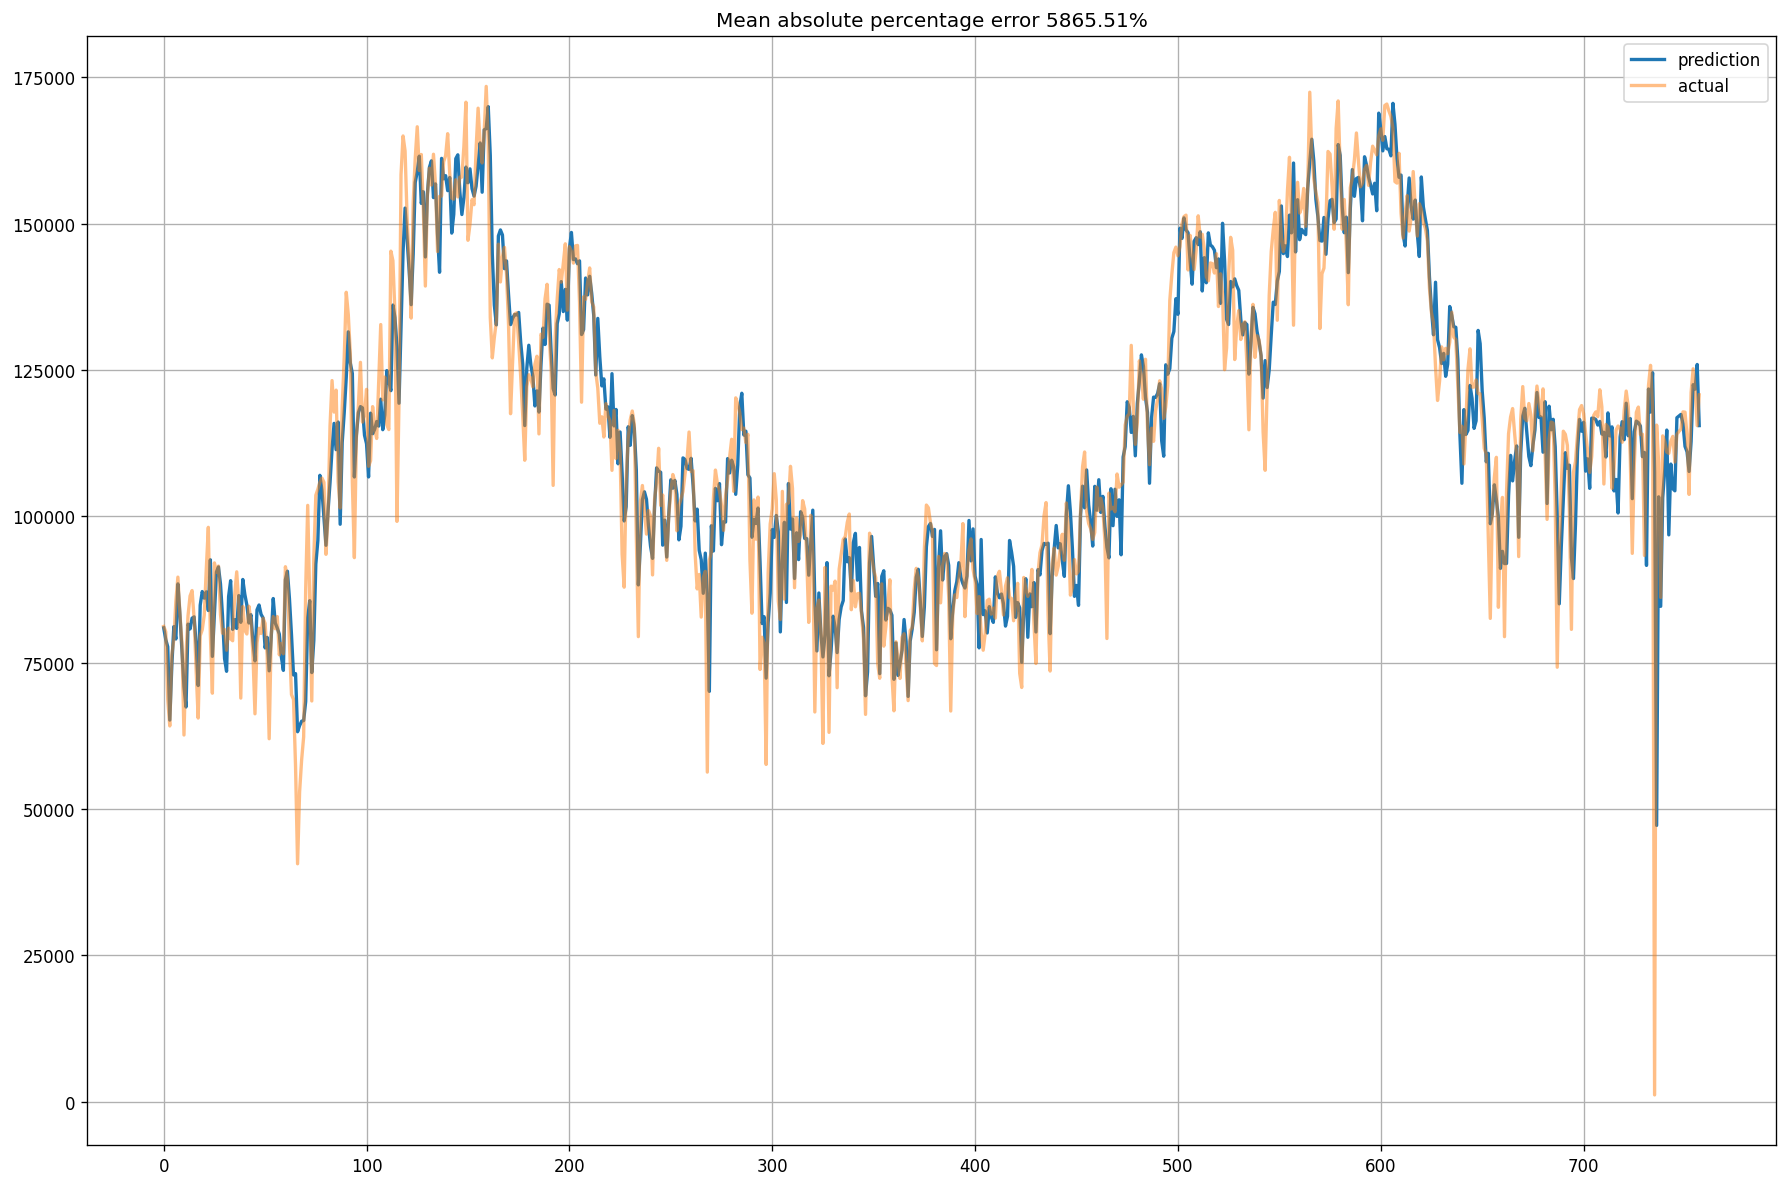

In [354]:
def plotModelTrainingResults(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, label="prediction", linewidth=2.0)
    plt.plot(y_train.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(prediction, y_train)
    mae_error_var = mean_absolute_error(prediction, y_train)
    mse_error_var = mse_error(prediction, y_train)
    rmse_error_var = rmse_error(prediction, y_train)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mae_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_train, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
train_results, train_mape_error_var, train_mae_error_var, train_mse_error_var, train_rmse_error_var = plotModelTrainingResults(lr)

In [365]:
train_results['residual'] = train_results['Actual'] - train_results['Prediction']

In [366]:
train_results.tail(10)

,Actual,Prediction,residual
end,,,
2021-02-24,114912.0,117425.571444,-2513.571444
2021-02-25,117852.8,115815.425810,2037.374190
2021-02-26,117811.2,111951.169211,5860.030789
2021-02-27,113801.6,111042.381954,2759.218046
2021-02-28,103753.6,107674.746903,-3921.146903
2021-03-01,121180.8,112767.729649,8413.070351
2021-03-02,125212.8,122500.589825,2712.210175
2021-03-03,121600.0,121751.251523,-151.251523
2021-03-04,115507.2,125950.346051,-10443.146051


<AxesSubplot:xlabel='end'>

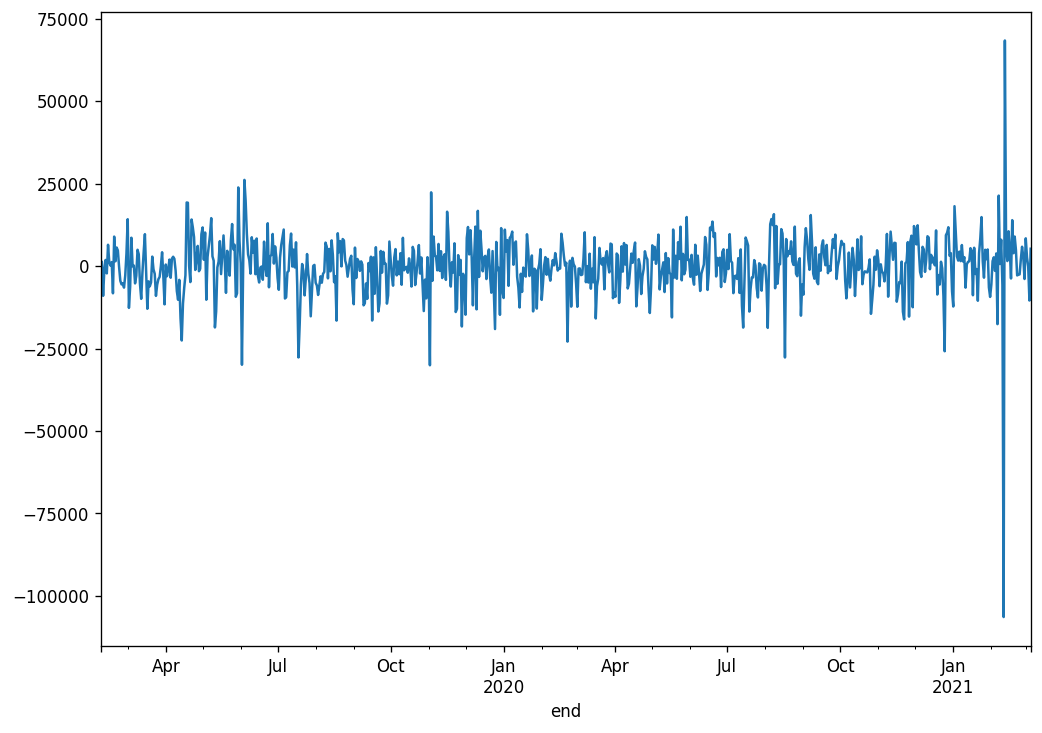

In [370]:
train_results['residual'].plot()

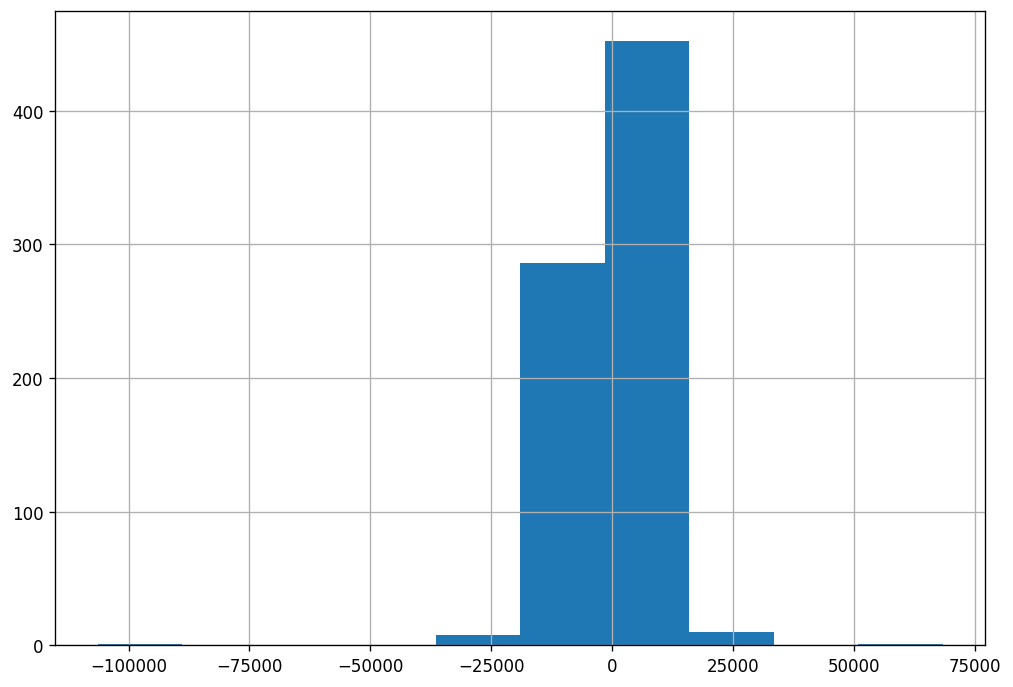

In [376]:
train_results['residual'].hist()
pyplot.show()

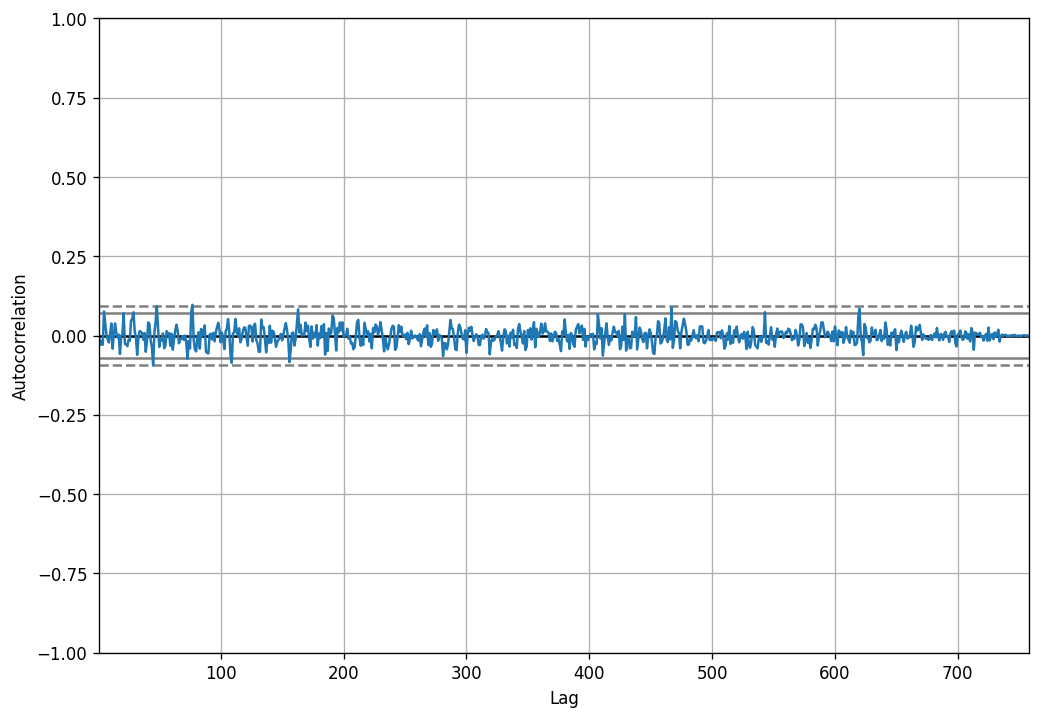

In [373]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

# autocorrelation
autocorrelation_plot(train_results['residual'])
pyplot.show()

In [356]:
print('MAPE: ' , train_mape_error_var)
print('MAE: ', train_mae_error_var)
print('MSE: ', train_mse_error_var)
print('RMSE: ', train_rmse_error_var)

MAPE:  5.604639718431051
MAE:  5865.51358733809
MSE:  76302163.37563978
RMSE:  8735.110953825359


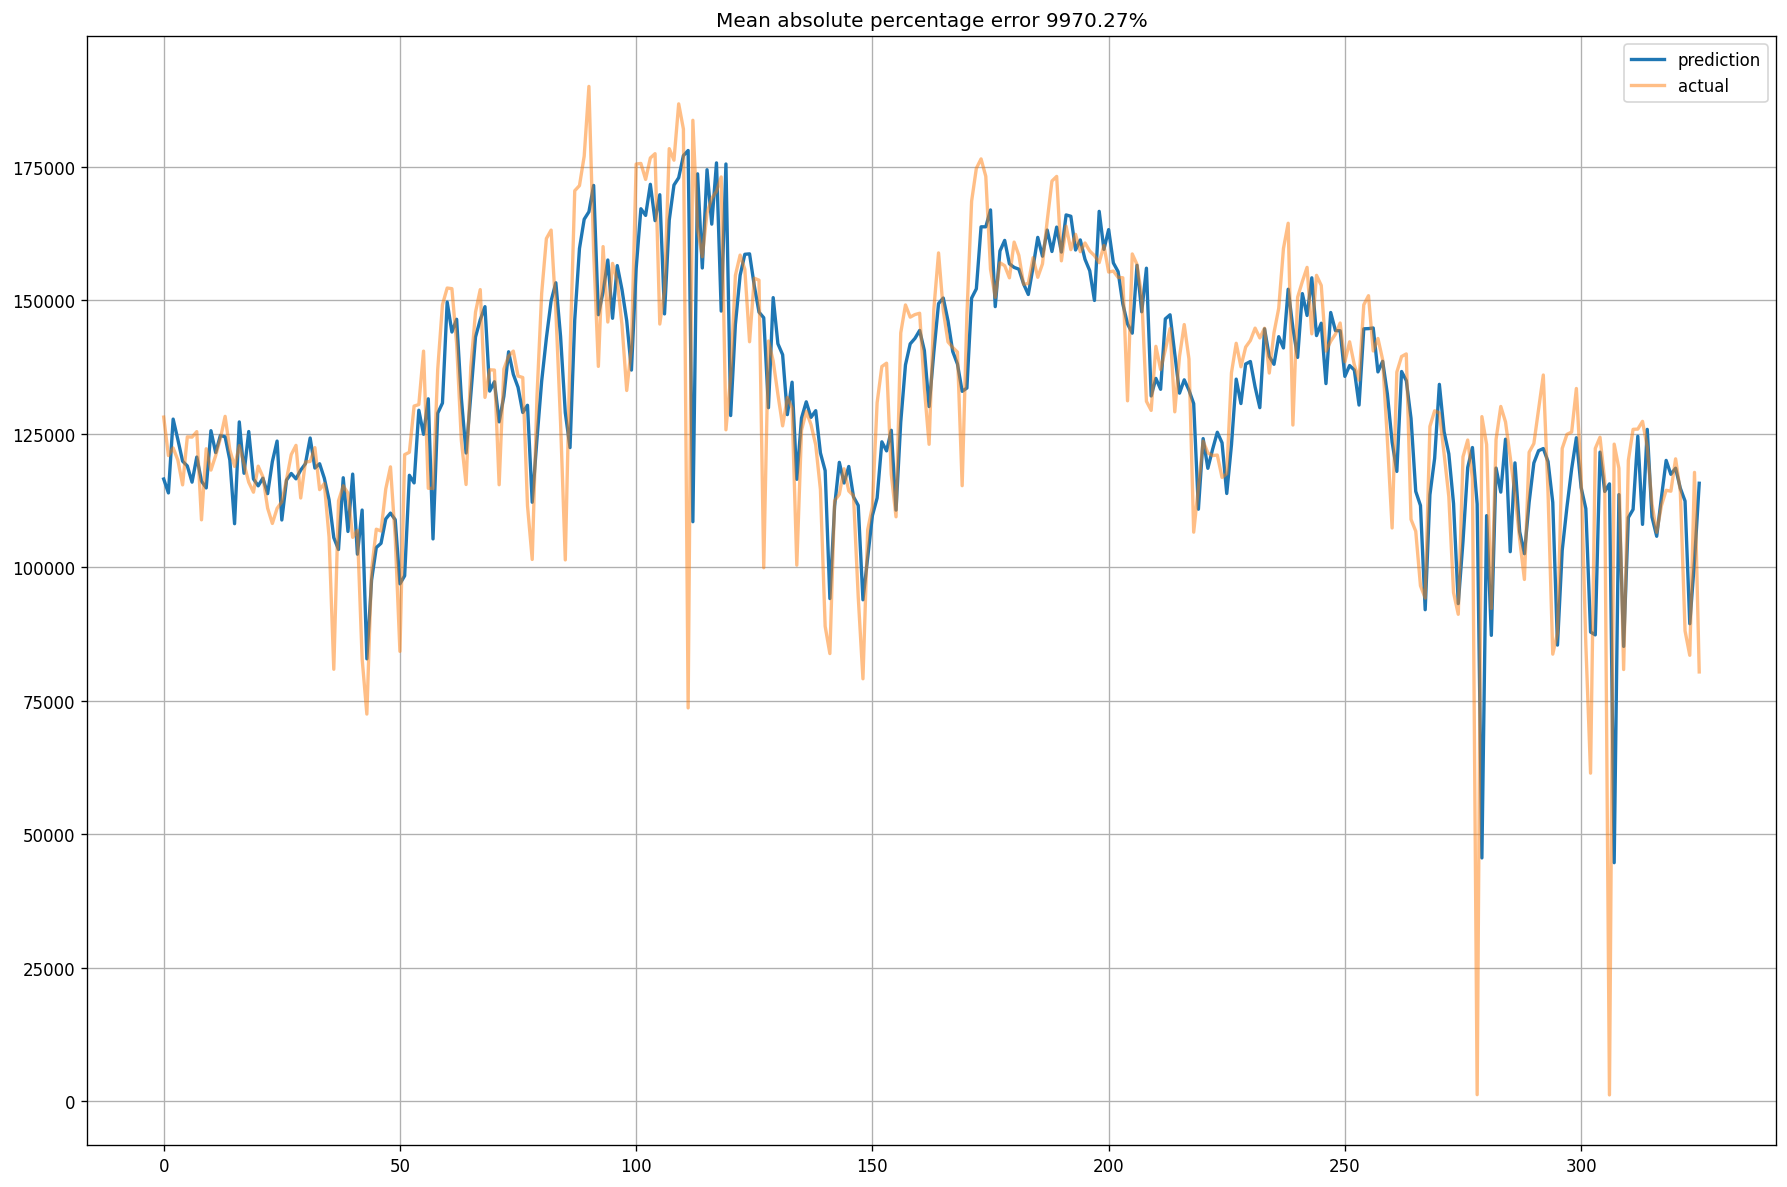

In [378]:
def plotModelPredictions(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(prediction, y_test)
    mae_error_var = mean_absolute_error(prediction, y_test)
    mse_error_var = mse_error(prediction, y_test)
    rmse_error_var = rmse_error(prediction, y_test)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mae_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_test, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var = plotModelPredictions(lr)

In [362]:
results['residual'] = results['Actual'] - results['Prediction']

In [363]:
results.tail(10)

,Actual,Prediction,residual
end,,,
2022-01-16,106560.0,105808.935257,751.064743
2022-01-17,111532.8,113069.406728,-1536.606728
2022-01-18,114422.4,120019.335031,-5596.935031
2022-01-19,114252.8,117409.724174,-3156.924174
2022-01-20,120313.6,118560.411269,1753.188731
2022-01-21,114214.4,114815.742771,-601.342771
2022-01-22,88096.0,112406.815283,-24310.815283
2022-01-23,83523.2,89440.681294,-5917.481294
2022-01-24,117772.8,101164.748645,16608.051355


<AxesSubplot:xlabel='end'>

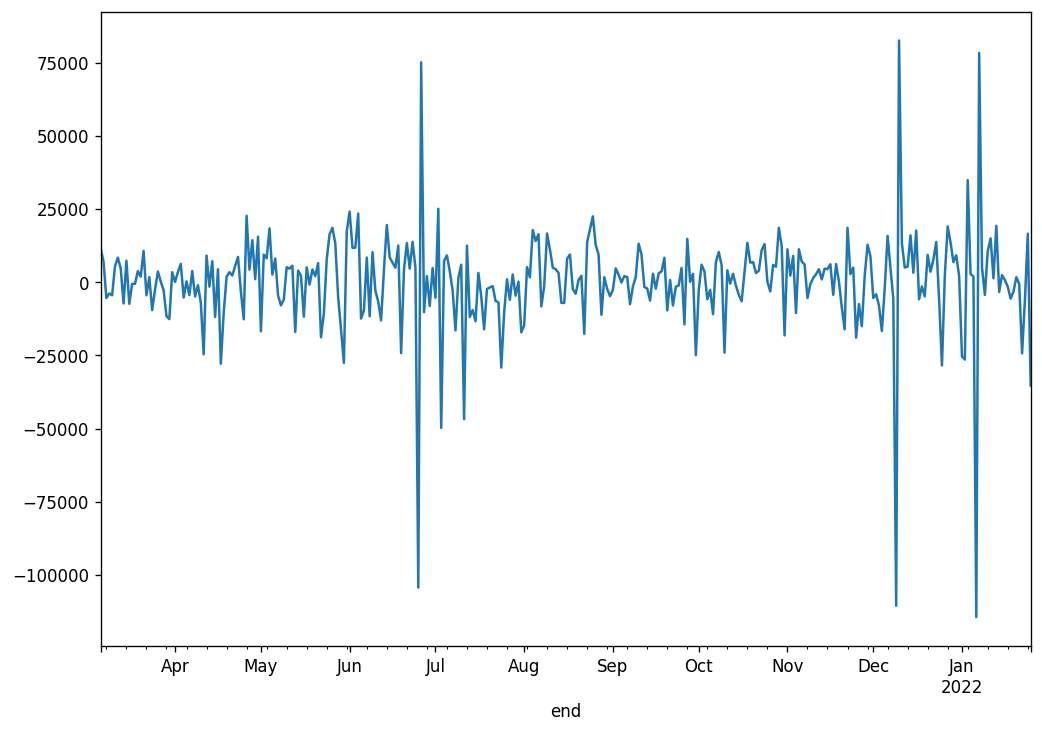

In [364]:
results['residual'].plot()

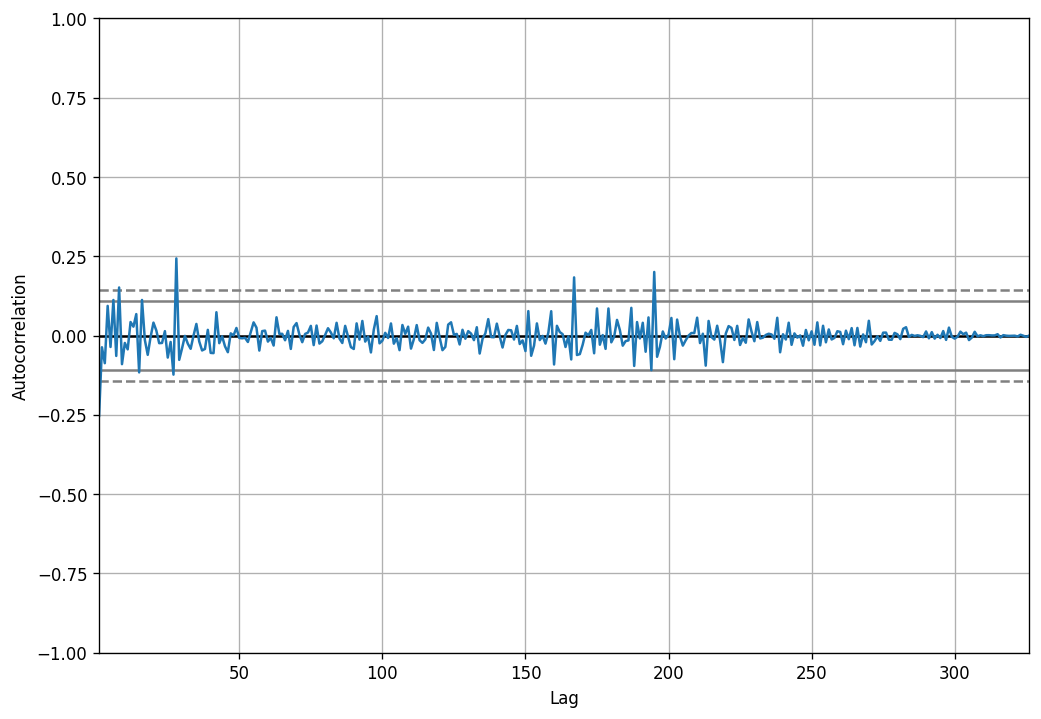

In [377]:
autocorrelation_plot(results['residual'])
pyplot.show()

In [359]:
print('MAPE: ' , mape_error_var)
print('MAE: ', mae_error_var)
print('MSE: ', mse_error_var)
print('RMSE: ', rmse_error_var)

MAPE:  8.534285723176296
MAE:  9970.268316532456
MSE:  291083708.4460152
RMSE:  17061.17547081722


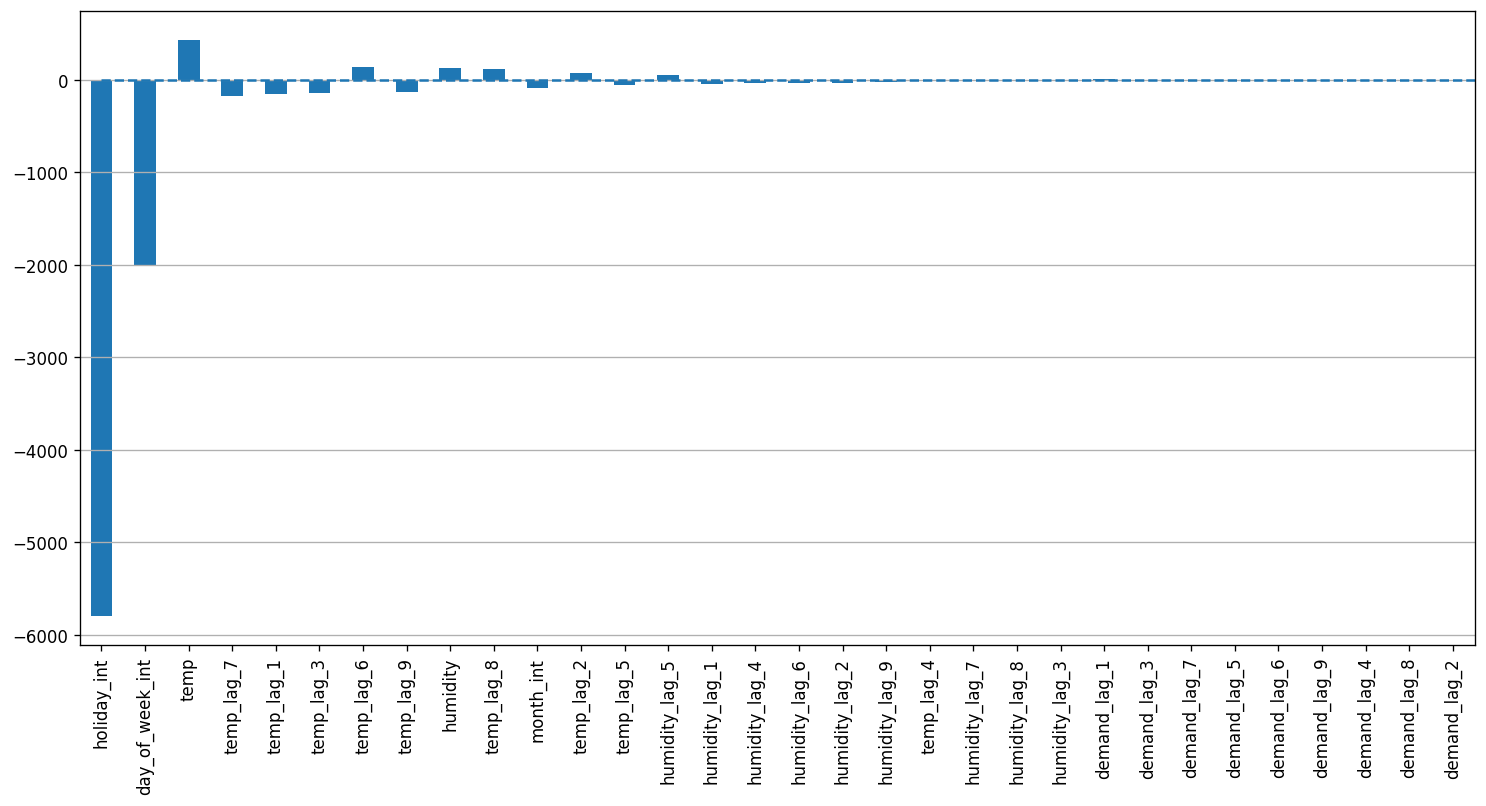

In [360]:
def plotCoefficients(model, maxDisplayValues=50):
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plot_coefs = coefs.head(maxDisplayValues)
    
    plt.figure(figsize=(15, 7))
    plot_coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(plot_coefs), linestyles='dashed');

plotCoefficients(lr)